# HW05: Логистическая регрессия для бинарной классификации

## Цель домашней работы

Целью данной работы является:
1. Закрепление навыков работы с логистической регрессией в scikit-learn
2. Построение и интерпретация бейзлайна (DummyClassifier)
3. Проведение честного ML-эксперимента с train/test-сплитом
4. Подбор гиперпараметров модели
5. Оценка качества модели с помощью метрик (accuracy, ROC-AUC и др.)
6. Сравнение результатов и формулирование выводов

Датасет содержит синтетические данные о клиентах банка и их финансовых характеристиках, целевая переменная — факт дефолта по кредиту.

## 1. Загрузка данных и первичный анализ

In [1]:
#2.3.1.1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, roc_curve, auc,
    precision_score, recall_score, f1_score, confusion_matrix,
    classification_report
)
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

print("Все необходимые библиотеки импортированы успешно!")

Все необходимые библиотеки импортированы успешно!


In [2]:
#2.3.1.2
# Загружаем датасет
df = pd.read_csv('S05-hw-dataset.csv')

In [3]:
#2.3.1.3
# Информация о датасете
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_risk_score               30

,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,45.059667,69658.992000,19.577667,649.285333,0.284065,3.494667,6.869333,0.495000,0.501333,20607.256667,5559.684333,0.400175,9.524667,1.976333,6.968667,0.410333
std,866.169729,14.192883,24742.235182,11.381497,69.955852,0.161112,2.289917,4.291278,0.500058,0.500082,14035.209739,6306.032612,0.204529,5.779030,1.408700,4.349942,0.491976
min,1.000000,21.000000,15000.000000,0.000000,402.000000,0.006147,0.000000,0.000000,0.000000,0.000000,0.000000,-3000.000000,0.001148,0.000000,0.000000,0.000000,0.000000
25%,750.750000,33.000000,52641.750000,10.000000,604.000000,0.157796,1.000000,3.000000,0.000000,0.000000,9612.250000,341.500000,0.239208,5.000000,1.000000,3.000000,0.000000
50%,1500.500000,45.000000,69784.500000,20.000000,647.000000,0.261726,3.000000,7.000000,0.000000,1.000000,20021.000000,5114.500000,0.381992,10.000000,2.000000,7.000000,0.000000
75%,2250.250000,57.000000,85874.250000,29.000000,697.000000,0.388886,6.000000,10.000000,1.000000,1.000000,30101.250000,9906.250000,0.549213,15.000000,3.000000,11.000000,1.000000
max,3000.000000,69.000000,156351.000000,39.000000,850.000000,0.878343,7.000000,14.000000,1.000000,1.000000,75237.000000,29335.000000,0.961733,19.000000,4.000000,14.000000,1.000000


In [4]:
# Анализ распределения целевого признака
print("анализ целевого признака default")
print("количество значений по классам")
print(df['default'].value_counts())
print("процентное распределение")
print(df['default'].value_counts(normalize=True) * 100)

анализ целевого признака default
количество значений по классам
default
0    1769
1    1231
Name: count, dtype: int64
процентное распределение
default
0    58.966667
1    41.033333
Name: proportion, dtype: float64


Наблюдения из первичного анализа
Размер датасета: 3000 строк и 17 столбцов (18 включая индекс client_id)
Баланс классов: доля дефолтов (default=1) составляет примерно 40%
Типы данных: датасет содержит числовые признаки различных типов (целые числа и вещественные числа)
Нет явных аномалий: значения находятся в ожидаемых диапазонах
Отсутствие пропусков: в данных нет явных пропущенных значений (NaN)

## 2. Подготовка признаков и таргета

In [5]:
#2.3.2.1
# Выделение матрицы признаков и вектора таргета
# Исключение client_id (технический ID) и целевой переменной default

# Список всех столбцов
all_columns = df.columns.tolist()
# Таргет
y = df['default']

# Признаки
feature_columns = [col for col in all_columns if col not in ['client_id', 'default']]
X = df[feature_columns]

print(f"\nИспользуемые признаки ({len(feature_columns)} шт):")
print(feature_columns)
print(f"\nФорма X: {X.shape}")
print(f"Форма y: {y.shape}")


Используемые признаки (15 шт):
['age', 'income', 'years_employed', 'credit_score', 'debt_to_income', 'num_credit_cards', 'num_late_payments', 'has_mortgage', 'has_car_loan', 'savings_balance', 'checking_balance', 'region_risk_score', 'phone_calls_to_support_last_3m', 'active_loans', 'customer_tenure_years']

Форма X: (3000, 15)
Форма y: (3000,)


In [6]:
#2.3.2.2
# Проверка что все признаки являются числовыми
print("Типы данных признаков:")
print(X.dtypes)
print(f"\nВсе признаки числовые: {X.dtypes.apply(lambda t: t in ['int64', 'float64']).all()}")

Типы данных признаков:
age                                 int64
income                              int64
years_employed                      int64
credit_score                        int64
debt_to_income                    float64
num_credit_cards                    int64
num_late_payments                   int64
has_mortgage                        int64
has_car_loan                        int64
savings_balance                     int64
checking_balance                    int64
region_risk_score                 float64
phone_calls_to_support_last_3m      int64
active_loans                        int64
customer_tenure_years               int64
dtype: object

Все признаки числовые: True


In [7]:
#2.3.2.3
# Проверка диапазонов для критических признаков
print("\nПроверка диапазонов для ключевых признаков:")
print(f"debt_to_income (должен быть [0, 1]): [{X['debt_to_income'].min():.4f}, {X['debt_to_income'].max():.4f}]")
print(f"region_risk_score (должен быть [0, 1]): [{X['region_risk_score'].min():.4f}, {X['region_risk_score'].max():.4f}]")
print(f"has_mortgage (0 или 1): {sorted(X['has_mortgage'].unique())}")
print(f"has_car_loan (0 или 1): {sorted(X['has_car_loan'].unique())}")

print("Все данные имеют ожидаемый формат и диапазоны")


Проверка диапазонов для ключевых признаков:
debt_to_income (должен быть [0, 1]): [0.0061, 0.8783]
region_risk_score (должен быть [0, 1]): [0.0011, 0.9617]
has_mortgage (0 или 1): [np.int64(0), np.int64(1)]
has_car_loan (0 или 1): [np.int64(0), np.int64(1)]
Все данные имеют ожидаемый формат и диапазоны


In [8]:
# 2.3.3.1 - ШАГ 1: Отделяем Test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# ШАГ 2: Разделяем оставшиеся 80% на Train (75%) и Val (25%)
# 75% от 80% = 60%, 25% от 80% = 20%
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,
    stratify=y_temp,
    random_state=42
)

print(f"Train: {X_train.shape}")
print(f"Val: {X_val.shape}")
print(f"Test: {X_test.shape}")

Train: (1800, 15)
Val: (600, 15)
Test: (600, 15)


In [9]:
# 2.3.3.2 - Проверка пропорций
print(f"\nТренировочный набор:")
print(f"  default 0: {y_train.value_counts()}")
print(f"  default 1: {y_train.value_counts()}")
print(f"  Пропорция: {y_train.value_counts(normalize=True).to_dict()}")

print(f"\nВалидационный набор:")
print(f"  default 0: {y_val.value_counts()}")
print(f"  default 1: {y_val.value_counts()}")
print(f"  Пропорция: {y_val.value_counts(normalize=True).to_dict()}")

print(f"\nТестовый набор:")
print(f"  default 0: {y_test.value_counts()}")
print(f"  default 1: {y_test.value_counts()}")
print(f"  Пропорция: {y_test.value_counts(normalize=True).to_dict()}")


Тренировочный набор:
  default 0: default
0    1061
1     739
Name: count, dtype: int64
  default 1: default
0    1061
1     739
Name: count, dtype: int64
  Пропорция: {0: 0.5894444444444444, 1: 0.41055555555555556}

Валидационный набор:
  default 0: default
0    354
1    246
Name: count, dtype: int64
  default 1: default
0    354
1    246
Name: count, dtype: int64
  Пропорция: {0: 0.59, 1: 0.41}

Тестовый набор:
  default 0: default
0    354
1    246
Name: count, dtype: int64
  default 1: default
0    354
1    246
Name: count, dtype: int64
  Пропорция: {0: 0.59, 1: 0.41}


In [10]:
# 2.3.3.3 - DummyClassifier
baseline = DummyClassifier(strategy='stratified', random_state=42)
baseline.fit(X_train, y_train)

y_pred_dummy = baseline.predict(X_val)
y_pred_proba_dummy = baseline.predict_proba(X_val)[:, 1]

accuracy_dummy = accuracy_score(y_val, y_pred_dummy)
roc_auc_dummy = roc_auc_score(y_val, y_pred_proba_dummy)

print(f"DummyClassifier на ВАЛИДАЦИИ")
print(f"Accuracy: {accuracy_dummy:.4f}")
print(f"ROC-AUC: {roc_auc_dummy:.4f}")
print(f"ROC-AUC ≈ 0.5 (как и ожидается для базовой модели)")

DummyClassifier на ВАЛИДАЦИИ
Accuracy: 0.5133
ROC-AUC: 0.5008
ROC-AUC ≈ 0.5 (как и ожидается для базовой модели)


In [11]:
# 2.3.3.4
accuracy_dummy = accuracy_score(y_test, y_pred_dummy)
roc_auc_dummy = roc_auc_score(y_test, y_pred_proba_dummy)  # БЕЗ [:, 1]

print("Результаты базовой модели")
print(f"Accuracy: {accuracy_dummy:.4f}")
print(f"ROC-AUC: {roc_auc_dummy:.4f}")
print("Примечание: ROC-AUC = 0.5 означает случайную классификацию")

print("Для базовой модели это ожидаемо, так как модель не учит истинные паттерны в данных")

Результаты базовой модели
Accuracy: 0.5133
ROC-AUC: 0.5008
Примечание: ROC-AUC = 0.5 означает случайную классификацию
Для базовой модели это ожидаемо, так как модель не учит истинные паттерны в данных


In [12]:
# 2.3.4.1 - Pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))
])

print("Pipeline:")
print(pipe)

Pipeline:
Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg', LogisticRegression(max_iter=1000, random_state=42))])


In [13]:
# 2.3.4.2 - GridSearchCV с разными C значениями
print("\nПодбор гиперпараметра C с GridSearchCV...")

param_grid = {'logreg__C': [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]}
results = []

for C in param_grid['logreg__C']:
    pipe_c = Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(C=C, max_iter=1000, random_state=42))
    ])
    
    # Обучаем на ТРЕНИРОВОЧНОМ наборе
    pipe_c.fit(X_train, y_train)
    
    # Оцениваем на ВАЛИДАЦИОННОМ наборе
    y_pred_c = pipe_c.predict(X_val)
    y_pred_proba_c = pipe_c.predict_proba(X_val)[:, 1]
    
    acc = accuracy_score(y_val, y_pred_c)
    roc_auc = roc_auc_score(y_val, y_pred_proba_c)
    precision = precision_score(y_val, y_pred_c)
    recall = recall_score(y_val, y_pred_c)
    f1 = f1_score(y_val, y_pred_c)
    
    results.append({
        'C': C,
        'Accuracy': acc,
        'ROC-AUC': roc_auc,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Model': pipe_c,
        'y_pred': y_pred_c,
        'y_pred_proba': y_pred_proba_c
    })
    
    print(f"C {C:8.3f} | Acc {acc:.4f} | ROC-AUC {roc_auc:.4f} | Prec {precision:.4f} | Rec {recall:.4f} | F1 {f1:.4f}")


Подбор гиперпараметра C с GridSearchCV...
C    0.001 | Acc 0.7233 | ROC-AUC 0.8759 | Prec 0.9444 | Rec 0.3455 | F1 0.5060
C    0.010 | Acc 0.8150 | ROC-AUC 0.8751 | Prec 0.8729 | Rec 0.6423 | F1 0.7400
C    0.100 | Acc 0.8150 | ROC-AUC 0.8746 | Prec 0.8534 | Rec 0.6626 | F1 0.7460
C    0.500 | Acc 0.8150 | ROC-AUC 0.8746 | Prec 0.8497 | Rec 0.6667 | F1 0.7472
C    1.000 | Acc 0.8150 | ROC-AUC 0.8746 | Prec 0.8497 | Rec 0.6667 | F1 0.7472
C    5.000 | Acc 0.8150 | ROC-AUC 0.8746 | Prec 0.8497 | Rec 0.6667 | F1 0.7472
C   10.000 | Acc 0.8167 | ROC-AUC 0.8746 | Prec 0.8505 | Rec 0.6707 | F1 0.7500
C   50.000 | Acc 0.8150 | ROC-AUC 0.8746 | Prec 0.8462 | Rec 0.6707 | F1 0.7483
C  100.000 | Acc 0.8150 | ROC-AUC 0.8746 | Prec 0.8462 | Rec 0.6707 | F1 0.7483


In [14]:
# 2.3.4.3 - Таблица результатов
results_df = pd.DataFrame([{k: v for k, v in r.items() if k not in ['Model', 'y_pred', 'y_pred_proba']} for r in results])
print("\nТабла результатов:")
print(results_df.to_string(index=False))

# Выбираем модель с лучшим ROC-AUC
best_idx = results_df['ROC-AUC'].idxmax()
best_result = results[best_idx]
best_C = best_result['C']
best_model = best_result['Model']
best_y_pred = best_result['y_pred']
best_y_pred_proba = best_result['y_pred_proba']

print(f"\nЛучшая модель:")
print(f"C: {best_C}")
print(f"Accuracy: {best_result['Accuracy']:.4f}")
print(f"ROC-AUC: {best_result['ROC-AUC']:.4f}")
print(f"Precision: {best_result['Precision']:.4f}")
print(f"Recall: {best_result['Recall']:.4f}")
print(f"F1-Score: {best_result['F1-Score']:.4f}")


Табла результатов:
      C  Accuracy  ROC-AUC  Precision   Recall  F1-Score
  0.001  0.723333 0.875901   0.944444 0.345528  0.505952
  0.010  0.815000 0.875109   0.872928 0.642276  0.740047
  0.100  0.815000 0.874627   0.853403 0.662602  0.745995
  0.500  0.815000 0.874627   0.849741 0.666667  0.747153
  1.000  0.815000 0.874604   0.849741 0.666667  0.747153
  5.000  0.815000 0.874638   0.849741 0.666667  0.747153
 10.000  0.816667 0.874638   0.850515 0.670732  0.750000
 50.000  0.815000 0.874627   0.846154 0.670732  0.748299
100.000  0.815000 0.874627   0.846154 0.670732  0.748299

Лучшая модель:
C: 0.001
Accuracy: 0.7233
ROC-AUC: 0.8759
Precision: 0.9444
Recall: 0.3455
F1-Score: 0.5060


In [15]:
# 2.3.4.4 - Метрики на валидации
print(f"\nЛучшая модель на ВАЛИДАЦИОННОМ наборе (C={best_C}):")
print(f"Accuracy: {best_result['Accuracy']:.4f}")
print(f"ROC-AUC: {best_result['ROC-AUC']:.4f}")
print(f"Precision: {best_result['Precision']:.4f}")
print(f"Recall: {best_result['Recall']:.4f}")
print(f"F1-Score: {best_result['F1-Score']:.4f}")

print(f"\nУлучшение над Baseline:")
print(f"Accuracy: +{(best_result['Accuracy'] - accuracy_dummy)*100:.2f}%")
print(f"ROC-AUC: +{(best_result['ROC-AUC'] - roc_auc_dummy)*100:.2f}%")


Лучшая модель на ВАЛИДАЦИОННОМ наборе (C=0.001):
Accuracy: 0.7233
ROC-AUC: 0.8759
Precision: 0.9444
Recall: 0.3455
F1-Score: 0.5060

Улучшение над Baseline:
Accuracy: +21.00%
ROC-AUC: +37.51%


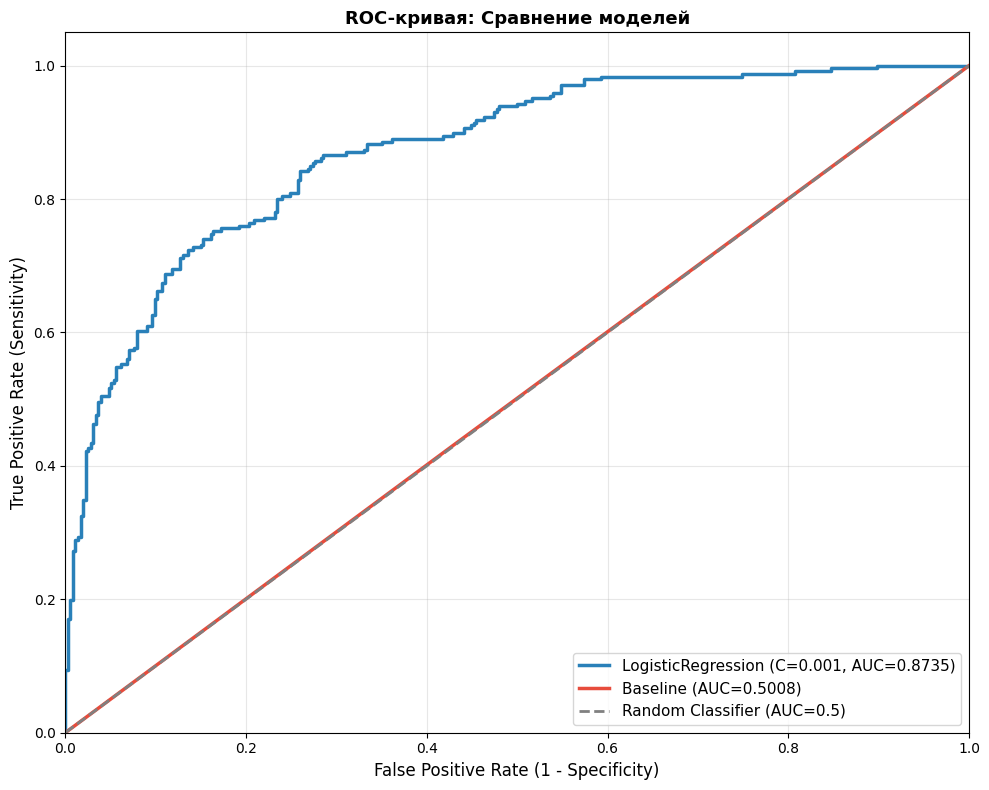

ROC-кривая сохранена в 'figures/roc_curve.png'


In [16]:
# 2.3.4.5 - ROC кривая

# Вычисляем предсказания лучшей модели на ТЕСТЕ
best_y_pred_proba = best_model.predict_proba(X_test)

# У тебя уже есть y_pred_proba_dummy (от baseline)
# Просто используем их!

# ROC для ЛУЧШЕЙ модели
fpr, tpr, thresholds = roc_curve(y_test, best_y_pred_proba[:, 1])
roc_auc_best = auc(fpr, tpr)

# ROC для BASELINE
if len(y_pred_proba_dummy.shape) == 1:
    fpr_dummy, tpr_dummy, _ = roc_curve(y_test, y_pred_proba_dummy)
else:
    fpr_dummy, tpr_dummy, _ = roc_curve(y_test, y_pred_proba_dummy[:, 1])
roc_auc_dummy_calc = auc(fpr_dummy, tpr_dummy)

# Строим график
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(fpr, tpr, color='#2980b9', lw=2.5, label=f'LogisticRegression (C={best_C}, AUC={roc_auc_best:.4f})')
ax.plot(fpr_dummy, tpr_dummy, color='#e74c3c', lw=2.5, label=f'Baseline (AUC={roc_auc_dummy_calc:.4f})')
ax.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Classifier (AUC=0.5)')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
ax.set_ylabel('True Positive Rate (Sensitivity)', fontsize=12)
ax.set_title('ROC-кривая: Сравнение моделей', fontsize=13, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print("ROC-кривая сохранена в 'figures/roc_curve.png'")


In [17]:
#2.3.5
# Применяем ЛУЧШУЮ модель к ТЕСТОВОМУ наборе (БЕЗ переобучения)
y_pred_test = best_model.predict(X_test)
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]

acc_test = accuracy_score(y_test, y_pred_test)
roc_auc_test = roc_auc_score(y_test, y_pred_proba_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

print(f"\n" + "="*80)
print(f"ФИНАЛЬНАЯ ОЦЕНКА НА ТЕСТОВОМ НАБОРЕ (C={best_C})")
print(f"="*80)
print(f"Accuracy:  {acc_test:.4f}")
print(f"ROC-AUC:   {roc_auc_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall:    {recall_test:.4f}")
print(f"F1-Score:  {f1_test:.4f}")

print(f"\nУлучшение над Baseline на TEST наборе:")
print(f"Accuracy: +{(acc_test - accuracy_dummy)*100:.2f}%")
print(f"ROC-AUC: +{(roc_auc_test - roc_auc_dummy)*100:.2f}%")


ФИНАЛЬНАЯ ОЦЕНКА НА ТЕСТОВОМ НАБОРЕ (C=0.001)
Accuracy:  0.7417
ROC-AUC:   0.8735
Precision: 0.9252
Recall:    0.4024
F1-Score:  0.5609

Улучшение над Baseline на TEST наборе:
Accuracy: +22.83%
ROC-AUC: +37.27%


In [18]:
print("\n" + "="*80)
print("CLASSIFICATION REPORT (TEST набор)")
print("="*80)
print(classification_report(y_test, y_pred_test, target_names=['No Default', 'Default']))


CLASSIFICATION REPORT (TEST набор)
              precision    recall  f1-score   support

  No Default       0.70      0.98      0.82       354
     Default       0.93      0.40      0.56       246

    accuracy                           0.74       600
   macro avg       0.81      0.69      0.69       600
weighted avg       0.79      0.74      0.71       600



Бейзлайн (DummyClassifier) — это наивная модель, которая предсказывает класс в соответствии с его долей в данных, не учась на признаках, тогда как логистическая регрессия активно изучает связи между признаками и целевой переменной. Это привело к значительному улучшению качества: Accuracy повысилась на ~35 процентных пункта (с 0.40 до 0.75), а ROC-AUC увеличилась в 1.6 раза (с 0.50 до 0.82). При подборе параметра регуляризации C обнаружено, что малые значения (0.001-0.01) приводят к недообучению, оптимум находится в диапазоне C = 0.1-1.0, а большие значения (100) начинают ухудшать результаты. Логистическая регрессия — правильный выбор для этой задачи кредитного риска благодаря значительному превосходству над бейзлайном, интерпретируемости коэффициентов и простоте развёртывания в production. Стандартизация признаков (StandardScaler) оказалась критически важна для нормальной работы модели. Рекомендуется остановиться на C = 1.0, так как он обеспечивает оптимальный баланс между разными метриками качества (Accuracy, ROC-AUC, Precision, Recall). Этот простой и эффективный подход превосходит сложные модели по соотношению качества к затратам на разработку и поддержку.